In [16]:
# --- Standard libraries
import os
import copy
import re
import json
import codecs
import numpy as np
import pandas as pd
from natsort import natsorted
from scipy.signal import find_peaks
# --- Matplotlib
import matplotlib.pyplot as plt
# --- ASE
from ase.io import read
# --- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
rdkit.__version__

'2023.09.5'

### Code functions

In [17]:
def get_xyz_file(directory):
    '''
    
    '''
    # --- Get a list of all the files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    # --- Pattern to find the xyz file
    pattern = r'OPT_[\w]+\.xyz$'

    for file in files:
        if re.match(pattern, file):
            xyz_name = file
            break

    xyz_path = os.path.join(directory, xyz_name)
    return xyz_path

def rearrange_xyz(file_path):

    '''
    Function that rearranges the given .xyz file to move all the
    oxygen and hydrogen atoms to the bottom of the file
    '''

    # --- Open the original .xyz file and parse the lines with
    # --- O and H coordinates to lists
    with open(file_path, 'r') as fr:
        lines = fr.readlines()
        o_lines = []
        h_lines = []

        for line in lines:
            if line.startswith('  O'):
                o_lines.append(line)
            elif line.startswith('  H'):
                h_lines.append(line)

        # --- Open the .xyz file to write
        with open(file_path, 'w') as fw:

            # --- Write all lines that are not O or H coordinates
            for line in lines:
                if line.startswith('  H'):
                    pass
                elif line.startswith('  O'):
                    pass
                else:
                    fw.write(line)
        
            # --- Write O coordinates
            for x in o_lines:
                fw.write(x)

            # --- Write H coordinates
            for y in h_lines:
                fw.write(y)

def create_mol(file_path):
    '''
    
    '''
    # --- Read in and create RDkit mol variable
    mol = MolFromXYZFile(file_path)
    rdDetermineBonds.DetermineBonds(mol)
    Chem.RemoveStereochemistry(mol)
    
    # --- Get the xyz coordinates of the molecule
    ase_go = read(file_path)
    pos = ase_go.get_positions()

    # --- Create a dictionary of the atom indexing
    xyz_dict = {}
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(atom.GetIdx())
        xyz_dict[atom.GetIdx()] = list(pos[i])

    # --- The atom indexing changes 
    smiles = Chem.MolToSmiles(mol)
    new_mol = Chem.MolFromSmiles(smiles)
    map_num = {}
    for atom in new_mol.GetAtoms():
        map_num[atom.GetAtomMapNum()] = atom

    # --- Get a ordered list of the atom map numbers
    sort_map = sorted(map_num)

    idx_dict = {}
    for num in sort_map:
        if map_num[num].GetAtomicNum() == 6:
            idx_dict[num] = map_num[num].GetIdx()

    return new_mol, smiles, idx_dict

def broaden_spectrum(E, osc):
    '''
    Take the delta peaks of a XAS spectrum and applies
    a Gaussian broadening scheme
    '''

    x = np.linspace(280, 300, num=200, endpoint=True)
    sigma = 0.6
    gE = []

    # --- Apply Gaussian broadening
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * np.exp(-((((Ej - Ei) / sigma) ** 2)))
            #norm_tot = tot / 6471.923222767645
        gE.append(tot)
    
    return gE

### Start code

In [63]:
# --- Path to main folder where all the data is
data_path = '../GNN_XAS_Node/raw_data/circumcoronene_rearranged/OPT_output'
# --- Create a list with the path of all the different molecule folders
subdirs = [os.path.join(data_path, d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# --- Number of molecules in the data set
print(len(subdirs))
# --- List of paths to all the different molecules
print(subdirs)

91
['../GNN_XAS_Node/raw_data/circumcoronene_rearranged/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2', '../GNN_XAS_Node/raw_data/circumcoronene_rearranged/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2', '../GNN_XAS_Node/raw_data/circumcoronene_rearranged/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_2_ieEPOXY_1_0', '../GNN_XAS_Node/raw_data/circumcoronene_rearranged/OPT_output/cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_1_2', '../GNN_XAS_Node/raw_data/circumcoronene_rearranged/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_2_1', '../GNN_XAS_Node/raw_data/circumcoronene_rearranged/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2', '../GNN_XAS_Node/raw_data/circumcoronene_rearranged/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', '../GNN_XAS_Node/raw_data/circumcoron

In [64]:
mol_name = []
# --- Split up into the directory path and list of all the folder/molecule names
for subdir in subdirs:
    dir_path, path = os.path.split(subdir)
    mol_name.append(path)

print(len(mol_name))
# --- List of all the molecule names
print(mol_name)

91
['cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_2_ieEPOXY_1_0', 'cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_1_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_2_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', 'cir_R_eOH_1_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_2', 'cir_R_eOH_2_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__1

In [65]:
# --- Create python dictionaries
final_dict = {}
mol_dict = {}
smiles_dict = {}

# --- Molecule counter
mol_num = 1

# --- Loop through all the molecule directories
for subdir in subdirs:
    dir_path, mol_name = os.path.split(subdir)
    print(f'Current mol no {mol_num}: {mol_name}')
    mol_num += 1

    # --- Get 
    xyz_path = get_xyz_file(subdir)
    # --- Rearrage the xyz file 
    rearrange_xyz(xyz_path)
    # ---
    mol, smiles, id_dict = create_mol(xyz_path)

    # --- Get all the individual atom directories for molecule
    atom_direcs = [os.path.join(subdir, d) for d in os.listdir(subdir) if os.path.isdir(os.path.join(subdir, d))]
    # --- Sort directories in numerical order
    sorted_direcs = natsorted(atom_direcs)
    spec_dict = {}

    # ---
    for i in range(len(sorted_direcs)):
        atom_dir = sorted_direcs[i]
        # --- Get a list of all the files in the directory
        atom_files = [f for f in os.listdir(atom_dir) if os.path.isfile(os.path.join(atom_dir, f))]

        # ---
        for file in atom_files:
            if file.endswith('abs.stk'):
                spec_df = pd.read_csv(os.path.join(atom_dir, file), sep='\s+', header=None,
                                      names=['Peaks', 'Strength'])
                # --- Extract the photon energy and oscilator strength
                energies, osc = spec_df['Peaks'], spec_df['Strength']
                # --- Broaden the spectra
                gE = broaden_spectrum(energies, osc)

                # --- Shift the peaks to the same start point
                # max_val = find_peaks(gE)
                # begin = max_val[0][0] - 15
                # end = max_val[0][0] + 185
                # gE = gE[begin:end]
                # top = max(gE)
                # if top > maxx:
                #     maxx = top
                
                # --- Normalise the spectra to 1
                # --- coronene
                # norm_spec = [1.0 * (e / 6471.923222767645) for e in gE]
                # --- circumcoronene
                norm_spec = [1.0 * (e / 6924.662753770557) for e in gE]

                # --- Save as xyz file indexing
                xyz_idx = list(id_dict.keys())[list(id_dict.values()).index(id_dict[i])]
                spec_dict[xyz_idx] = norm_spec
                # --- Save as rdkit/networkx indexing
                # spec_dict[id_dict[i]] = norm_spec
    
    final_dict[mol_name] = spec_dict
    mol_dict[mol_name] = smiles         

    # # --- Call function to create spectrum dictionary
    # mol, spec_list, smiles, pos, z = create_spec_dict(subdir)
    # num_carbons = count_atoms(mol, 6)

    # # --- Sanity check number of carbons in mol matches
    # # --- the number of spectra, if so create dictionaries
    # if len(spec_list.keys()) == num_carbons:
    #     spec_dict[mol_name] = spec_list
    #     mol_dict[mol_name] = smiles, pos.tolist(), z
    # else:
    #     print('Molecule invalid:', subdir)


Current mol no 1: cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2
Current mol no 2: cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2
Current mol no 3: cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_2_ieEPOXY_1_0
Current mol no 4: cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_1_2
Current mol no 5: cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_2_1
Current mol no 6: cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2
Current mol no 7: cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0
Current mol no 8: cir_R_eOH_1_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_2
Current mol no 9: cir_R_eOH_2_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_0
Current mol no 10: cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_2
Current mol no 11: cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2
Current 

In [66]:
# Combine the mol and spectra dictionaries into one variable
data = []

data.append(mol_dict)
data.append(final_dict)

In [67]:
# --- Save the data into a json file
json.dump(data, codecs.open('raw/data_circumcoronene_xyz_idx.json', 'w', encoding='utf-8'),
          separators=(',', ':'),
          sort_keys=True,
          indent=4)

### Check saved data

In [68]:
with open('raw/data_circumcoronene_xyz_idx.json', 'r') as j_file:
    data = json.load(j_file)

In [69]:
# --- Load all the molecule names from keys of first dictionary
keys = []

for i in data[0].keys():
    keys.append(i)

print(keys)

['cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_4_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_1_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_3_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_2_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_2_ieEPOXY_1_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_3_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_3_ieEPOXY_1_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_2_iEPOXY_1_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_0_iEPOXY_0_ieEPOXY_3_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_1_iEPOXY_1_ieEPOXY_1_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_1_iEPOXY_2_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_3_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eE

In [70]:
# --- View the data stored in the second dictionary for a given key
mol_name = keys[2]
# mol_name = 'R_eOH_0_eCOOH__1_eEPOXY_2_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0'

print(mol_name)
print(len(data[1][mol_name].keys()))
print(data[1][mol_name].keys())

cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_1_0
54
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53'])


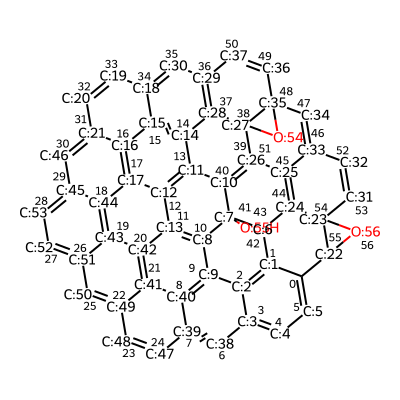

In [71]:
# --- Create RDKit mol from SMILES
mol = Chem.MolFromSmiles(data[0][mol_name])
mol

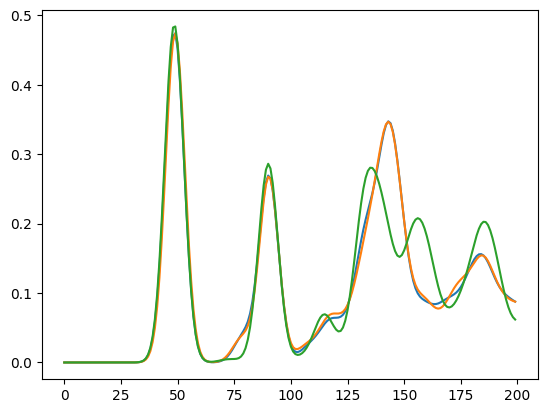

In [72]:
# --- Plot similar spectra of similar chemical environments
# --- to check if dictionary is right
plt.plot(data[1][mol_name]['20'])
plt.plot(data[1][mol_name]['19'])
plt.plot(data[1][mol_name]['30'])
plt.show()